In [ ]:
# ============================================
# INSTALLATION & SETUP
# ============================================
# Run this cell first, then restart kernel before running the rest

!pip install --upgrade ml_dtypes
!pip install tensorflow==2.18.0
!pip install pillow==10.0.0
!pip install matplotlib==3.9.2
!pip install numpy==2.0.2

print("\n✓ Installation complete!")
print("⚠️  IMPORTANT: Please restart your kernel now before proceeding!")
print("   (Kernel → Restart in Jupyter, or Runtime → Restart in Colab)")

  Using cached ml_dtypes-0.5.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.9 kB)
Using cached ml_dtypes-0.5.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (5.0 MB)
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.4 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.18.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.18.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.18.0 which is incompatible.


  Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # ← Updated line
import matplotlib.pyplot as plt
import numpy as np

print("✓ All imports successful!")
print(f"TensorFlow version: {tf.__version__}")

✓ All imports successful!
TensorFlow version: 2.18.0


In [2]:
# ============================================
# MOUNT GOOGLE DRIVE (FOR GOOGLE COLAB)
# ============================================
from google.colab import drive
drive.mount('/content/drive')
print("✓ Google Drive mounted successfully!\n")

# ============================================
# STEP 1: CONFIGURATION
# ============================================
# UPDATE THESE PATHS TO YOUR DATASET LOCATION FROM MY GOOGLE DRIVE

TRAIN_DIR = '/content/drive/MyDrive/Colab Notebooks/ML_Learning/coin_dataset/train'
VALIDATION_DIR = '/content/drive/MyDrive/Colab Notebooks/ML_Learning/coin_dataset/validation'

# Image parameters
IMG_SIZE = (224, 224)  # MobileNetV2 expects 224x224 images
BATCH_SIZE = 16        # Process 16 images at a time
EPOCHS = 20            # Number of training cycles

Mounted at /content/drive
✓ Google Drive mounted successfully!



In [3]:
# ============================================
# STEP 2: DATA AUGMENTATION & LOADING
# ============================================
print("Setting up data augmentation...")

# Training data augmentation - creates variations of your images
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to 0-1
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally
    height_shift_range=0.2,      # Randomly shift images vertically
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Randomly flip images
    fill_mode='nearest'          # Fill in new pixels after transformations
)

# Validation data - only normalize, no augmentation
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
print("Loading training images...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Multi-class classification
)

print("Loading validation images...")
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Get number of coin types
num_classes = len(train_generator.class_indices)
print(f"\n✓ Found {num_classes} different coin types")
print(f"✓ Training images: {train_generator.samples}")
print(f"✓ Validation images: {validation_generator.samples}")
print(f"\nCoin types: {list(train_generator.class_indices.keys())}\n")


Setting up data augmentation...
Loading training images...
Found 161 images belonging to 23 classes.
Loading validation images...
Found 69 images belonging to 23 classes.

✓ Found 23 different coin types
✓ Training images: 161
✓ Validation images: 69

Coin types: ['coin_1', 'coin_10', 'coin_11', 'coin_12', 'coin_13', 'coin_14', 'coin_15', 'coin_16', 'coin_17', 'coin_18', 'coin_19', 'coin_2', 'coin_20', 'coin_21', 'coin_22', 'coin_23', 'coin_3', 'coin_4', 'coin_5', 'coin_6', 'coin_7', 'coin_8', 'coin_9']



In [4]:
# ============================================
# STEP 3: BUILD MODEL WITH TRANSFER LEARNING
# ============================================
print("Building model with MobileNetV2...")

# Load pre-trained MobileNetV2 (trained on ImageNet)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,          # Don't include ImageNet classification layer
    weights='imagenet'           # Use weights from ImageNet training
)

# Freeze the base model (don't retrain these layers initially)
base_model.trainable = False

# Build your custom model on top
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),        # Prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # Output layer for your coins
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model built successfully!\n")
model.summary()

Building model with MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ Model built successfully!



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,424,919 (9.25 MB)

 Trainable params: 166,935 (652.09 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# ============================================
# STEP 4: TRAIN THE MODEL
# ============================================
print("\n" + "="*50)
print("STARTING TRAINING...")
print("="*50 + "\n")

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1
)

print("\n✓ Initial training completed!")



STARTING TRAINING...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 90s 8s/step - accuracy: 0.0190 - loss: 3.6646 - val_accuracy: 0.2174 - val_loss: 2.8061
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.1363 - loss: 2.8173 - val_accuracy: 0.3623 - val_loss: 2.4748
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2270 - loss: 2.5965 - val_accuracy: 0.4928 - val_loss: 2.1282
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3570 - loss: 2.2710 - val_accuracy: 0.6087 - val_loss: 1.8785
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4148 - loss: 1.7639 - val_accuracy: 0.5797 - val_loss: 1.5688
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5303 - loss: 1.6257 - val_accuracy: 0.7536 - val_loss: 1.3615
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5486 - loss: 1.5142 - val_accuracy: 0.7536 - val_loss: 1.2399
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5716 - loss: 1.3315 - val_accuracy: 0.7391 - val_loss:

In [6]:
# ============================================
# STEP 5: FINE-TUNING (OPTIONAL BUT RECOMMENDED)
# ============================================
print("\n" + "="*50)
print("FINE-TUNING MODEL...")
print("="*50 + "\n")

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Freeze early layers, only train last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=10,  # Additional 10 epochs
    validation_data=validation_generator,
    verbose=1
)

print("\n✓ Fine-tuning completed!")


FINE-TUNING MODEL...

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6735 - loss: 1.0348 - val_accuracy: 0.8841 - val_loss: 0.4558
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7834 - loss: 0.7945 - val_accuracy: 0.8116 - val_loss: 0.4542
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9194 - loss: 0.3750 - val_accuracy: 0.8261 - val_loss: 0.5094
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9122 - loss: 0.3592 - val_accuracy: 0.7971 - val_loss: 0.6044
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8932 - loss: 0.3254 - val_accuracy: 0.7971 - val_loss: 0.6666
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9766 - loss: 0.1778 - val_accuracy: 0.7826 - val_loss: 0.6691
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9256 - loss: 0.2689 - val_accuracy: 0.7681 - val_loss: 0.6505
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9503 - loss: 0.2188 - val_accur

In [7]:
# ============================================
# STEP 6: SAVE THE MODEL TO GOOGLE DRIVE
# ============================================
# Save to Google Drive so you can access it from prediction notebook
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/ML_Learning/coin_classifier_model.keras'
LABELS_PATH = '/content/drive/MyDrive/Colab Notebooks/ML_Learning/coin_labels.json'

model.save(SAVE_PATH)
print(f"\n✓ Model saved to Google Drive: {SAVE_PATH}")

# Save class labels
import json
class_labels = {v: k for k, v in train_generator.class_indices.items()}
with open(LABELS_PATH, 'w') as f:
    json.dump(class_labels, f, indent=4)
print(f"✓ Class labels saved to: {LABELS_PATH}")


✓ Model saved to Google Drive: /content/drive/MyDrive/Colab Notebooks/ML_Learning/coin_classifier_model.keras
✓ Class labels saved to: /content/drive/MyDrive/Colab Notebooks/ML_Learning/coin_labels.json


✓ Training plots saved as 'training_history.png'


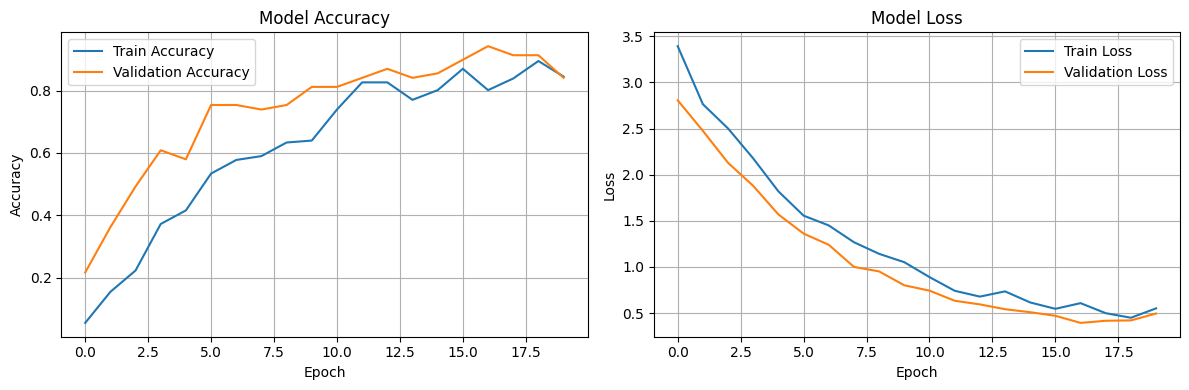

In [8]:
# ============================================
# STEP 7: PLOT TRAINING HISTORY
# ============================================
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
print("✓ Training plots saved as 'training_history.png'")
plt.show()

In [9]:
# ============================================
# STEP 8: EVALUATE FINAL MODEL
# ============================================
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"\nValidation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)
print("\nNext steps:")
print("1. Use 'coin_prediction.py' to test your model on new coins")
print("2. If accuracy is low (<85%), collect more images")
print("3. Ensure good photo quality and variety")


FINAL EVALUATION
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 946ms/step - accuracy: 0.7224 - loss: 0.8412

Validation Accuracy: 72.46%
Validation Loss: 0.7813

TRAINING COMPLETE!

Next steps:
1. Use 'coin_prediction.py' to test your model on new coins
2. If accuracy is low (<85%), collect more images
3. Ensure good photo quality and variety
